In [1]:
import torch
import torch2trt
import matplotlib.pyplot as plt
import cv2

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-j0tu7w_e because the default path (/home/brian/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [3]:
model = torch.load('/home/brian/models/weights.pt')

In [4]:
model = model.cuda().eval().half()

In [5]:
ino = 858
# Read  a sample image and mask from the data-set
img = cv2.imread(f'/home/brian/mycar/data/tub_47_20-10-15/{ino:03d}_cam-image1_.jpg')

In [10]:
def equalize(im):
    gray = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
    # create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cli = clahe.apply(gray)
    im2 = cv2.cvtColor(cli,cv2.COLOR_GRAY2RGB)
    return im2

In [11]:
img2 = equalize(img)
crop_img = img2[250:550, 125:775].copy()

In [12]:
img3 = crop_img.transpose(2,0,1).reshape(1,3,300,650)

In [13]:
input = torch.from_numpy(img3).type(torch.cuda.HalfTensor)/255

In [15]:
import time

torch.cuda.current_stream().synchronize()
t0 = time.time()
with torch.no_grad():
    output = model(input)
torch.cuda.current_stream().synchronize()
t1 = time.time()
print(1.0 / (t1 - t0))

0.2615562993426458


In [16]:
output['out'].shape

torch.Size([1, 1, 300, 650])

(array([   531., 154859.,   1448.,   1064.,    906.,    874.,    897.,
          1000.,   1651.,  31770.]),
 array([-0.2017 , -0.0815 ,  0.03867,  0.1588 ,  0.279  ,  0.3992 ,
         0.5195 ,  0.6396 ,  0.76   ,  0.88   ,  1.     ], dtype=float16),
 <BarContainer object of 10 artists>)

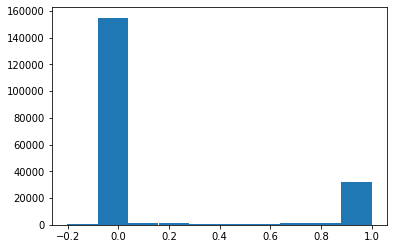

In [17]:
plt.hist(output['out'].data.cpu().numpy().flatten())

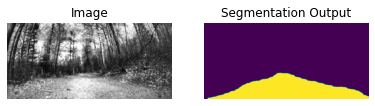

In [18]:
plt.figure(figsize=(10,10));
plt.subplot(131);
plt.imshow(img3[0,...].transpose(1,2,0));
plt.title('Image')
plt.axis('off');
plt.subplot(132);
plt.imshow(output['out'].cpu().detach().numpy()[0][0]>0.4);
plt.title('Segmentation Output')
plt.axis('off');